In [1]:
'''
finetuned deberta eval scripts
'''

'\nfinetuned deberta eval scripts\n'

In [80]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding, AdamW, get_scheduler
from tqdm.auto import tqdm
import pandas as pd
from sklearn.metrics import classification_report

from torch.nn import Softmax

from sklearn.metrics import (precision_recall_curve,
                             PrecisionRecallDisplay)

import pickle

In [3]:
model_name = 'microsoft/deberta-v3-base'

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/mnt/c/Users/hew7/documents/venvs/pythia/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
#load finetuned weights

MODEL_WEIGHT_PATH="deberta_finetune_epoch1"

model.load_state_dict(torch.load(MODEL_WEIGHT_PATH, weights_only=True))

model.to(device)

DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): Dropout(p=0.1, inplace=False)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Layer

In [5]:

#load test set

class BiaslyDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.texts = dataframe['datapoint'].tolist()
        self.labels = dataframe['misogynistic_label'].tolist()
        
        # Tokenize in the constructor
        self.encodings = tokenizer(self.texts, truncation=True, padding=True, max_length=512)
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

with open("test_set.pickle", "rb") as f:
    test_set=pickle.load(f)

In [6]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

test_dataloader = DataLoader(
    test_set, batch_size=4, collate_fn=data_collator
)
test_results = []
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    outputs = model(**batch)
    test_results.extend(outputs.logits.tolist())

In [17]:
y_true = [float(x['labels']) for x in test_set]

In [78]:
m=Softmax()
softmax = m(torch.tensor(test_results))
probs = np.array(softmax)[:,1].reshape(-1,1)

/tmp/ipykernel_10728/237467202.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  probs = np.array(softmax)[:,1].reshape(-1,1)


In [79]:
#naive rounding
results_pred = [np.round(x[0]) for x in probs.tolist()]

print(classification_report(results_pred, y_true))

              precision    recall  f1-score   support

         0.0       0.71      0.91      0.80       755
         1.0       0.78      0.47      0.58       516

    accuracy                           0.73      1271
   macro avg       0.74      0.69      0.69      1271
weighted avg       0.74      0.73      0.71      1271



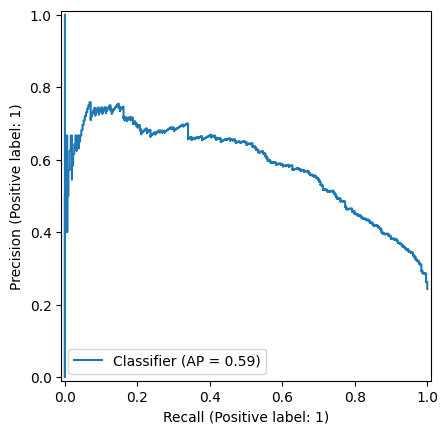

In [81]:
#picking threshold based on precision-recall curve

PrecisionRecallDisplay.from_predictions(
   y_true, probs)

In [82]:
#custom threshold
results_pred_threshold = [1 if x[0]>=0.75 else 0 for x in probs.tolist()]

print(classification_report(results_pred_threshold, y_true))

              precision    recall  f1-score   support

           0       0.85      0.88      0.86       921
           1       0.65      0.57      0.61       350

    accuracy                           0.80      1271
   macro avg       0.75      0.73      0.74      1271
weighted avg       0.79      0.80      0.79      1271

